In [1]:
import xarray as xr

/group/pawsey0106/miniconda3/envs/c3dis/envs/c3dis2/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/group/pawsey0106/miniconda3/envs/c3dis/envs/c3dis2/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(scheduler_port=8789)
cluster

/group/pawsey0106/miniconda3/envs/c3dis/envs/c3dis2/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
# from distributed import LocalCluster
# cluster = LocalCluster(n_workers=3,threads_per_worker=1)
# cluster

In [3]:
from distributed import Client
# client=Client(cluster)
client=Client('tcp://localhost:8789')
client

Client Scheduler: tcp://localhost:8789 Dashboard: http://localhost:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### 1. Against the netCDFs on the thredds server

In [4]:
#Saved these URLs earlier - see Example 2
import yaml
with open('K490_url_2014.yml', 'r') as infile:
    all_urls=yaml.safe_load(infile)
all_urls[0:10]

['http://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/OC/gridded/aqua/P1D/2014/01/A.P1D.20140101T000000Z.aust.K_490.nc',
 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/OC/gridded/aqua/P1D/2014/01/A.P1D.20140102T000000Z.aust.K_490.nc',
 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/OC/gridded/aqua/P1D/2014/01/A.P1D.20140103T000000Z.aust.K_490.nc',
 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/OC/gridded/aqua/P1D/2014/01/A.P1D.20140104T000000Z.aust.K_490.nc',
 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/OC/gridded/aqua/P1D/2014/01/A.P1D.20140105T000000Z.aust.K_490.nc',
 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/OC/gridded/aqua/P1D/2014/01/A.P1D.20140106T000000Z.aust.K_490.nc',
 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/OC/gridded/aqua/P1D/2014/01/A.P1D.20140107T000000Z.aust.K_490.nc',
 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/OC/gridded/aqua/P1D/2014/01/A.P1D.20140108T000000Z.aust.K_490.nc',
 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/

Open the dataset with xarray with each file in parallel using dask. Chunks alinged with netcdf file chunks

In [ ]:
ds_thredds = xr.open_mfdataset(all_urls,chunks={'latitude':856*3,'longitude':1223*3},parallel=True) 
# ds_thredds = xr.open_mfdataset(all_urls,chunks={'time':1},parallel=True) 
ds_thredds

Calculate the monthly means over 12 months of daily files. This makes approximately 30k opendap requests(!) and takes a little while to run. Works, but not all that well. Should probably optimise chunk size (increase)

In [ ]:
import time

start = time.time()
monthly_mean = ds_thredds.groupby('time.month').mean('time').compute() 
end = time.time()
print('Elapsed time: %.2f s' % (end - start))

monthly_mean

### 2. Against the netCDFs on S3 directly 

New functionality provided by s3fs+h5netcdf using file like objects - doesnt work with open_mfdataset (yet!). But we can mimic the functionality of open_mfdataset using a dask delayed function call. Pretty slow, essentially just downloading the files to a memory cache... I think. So makes sense to chunk on a file basis.

In [29]:
import s3fs
from dask import delayed, compute
@delayed 
def open_s3_dataset(s3path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    fobj = fs.open(s3path)
    return xr.open_dataset(fobj,engine='h5netcdf',chunks={'time':1})

all_files = []
fs = s3fs.S3FileSystem(anon=True)
months = fs.ls('imos-data/IMOS/SRS/OC/gridded/aqua/P1D/2014')
for month in months:
    this_month = [f for f in fs.ls(month) if 'K_490' in f]
    all_files=all_files+this_month

futures = [open_s3_dataset(s3path) for s3path in all_files]

datasets = compute(futures)[0]

ds_s3netcdf = xr.concat(datasets,dim='time')
ds_s3netcdf

<xarray.Dataset>
Dimensions:    (latitude: 7001, longitude: 10001, time: 365)
Coordinates:
  * latitude   (latitude) float64 10.0 9.99 9.98 9.97 ... -59.98 -59.99 -60.0
  * longitude  (longitude) float64 80.0 80.01 80.02 80.03 ... 180.0 180.0 180.0
  * time       (time) datetime64[ns] 2014-01-01 2014-01-02 ... 2014-12-31
Data variables:
    K_490      (time, latitude, longitude) float32 dask.array<shape=(365, 7001, 10001), chunksize=(1, 7001, 10001)>
Attributes:
    history:      File initialised at 2015-12-16T15:53:48.785210\nInitialised...
    Conventions:  CF-1.6
    source_path:  imos-srs/archive/oc/aqua/1d/v201508/2014/01/A20140101.L2OC_...

Calculate the monthly mean as above again - this is also pretty slow, but it works!

In [ ]:
import time

start = time.time()
monthly_mean = ds_s3netcdf.groupby('time.month').mean('time').compute() 
end = time.time()
print('Elapsed time: %.2f s' % (end - start))

monthly_mean

### 3. Against the netCDFs on local (Lustre - fast!) file system 

Chunked according to the netCDF file chunking used

In [24]:
import glob, os
files = glob.glob(os.environ['MYSCRATCH'] + '/aqua_files/*2014*')
files = sorted(files)

ds_netcdf = xr.open_mfdataset(files,chunks={'latitude':856,'longitude':1223},parallel=True) 
ds_netcdf


<xarray.Dataset>
Dimensions:    (latitude: 7001, longitude: 10001, time: 365)
Coordinates:
  * latitude   (latitude) float64 10.0 9.99 9.98 9.97 ... -59.98 -59.99 -60.0
  * longitude  (longitude) float64 80.0 80.01 80.02 80.03 ... 180.0 180.0 180.0
  * time       (time) datetime64[ns] 2014-01-01 2014-01-02 ... 2014-12-31
Data variables:
    K_490      (time, latitude, longitude) float32 dask.array<shape=(365, 7001, 10001), chunksize=(1, 856, 1223)>
Attributes:
    history:      File initialised at 2015-12-16T15:53:48.785210\nInitialised...
    Conventions:  CF-1.6
    source_path:  imos-srs/archive/oc/aqua/1d/v201508/2014/01/A20140101.L2OC_...

In [33]:
import time

start = time.time()
monthly_mean = ds_netcdf.groupby('time.month').mean('time').compute() 
end = time.time()
print('Elapsed time: %.2f s' % (end - start))

monthly_mean

Elapsed time: 189.78 s


<xarray.Dataset>
Dimensions:    (latitude: 7001, longitude: 10001, month: 12)
Coordinates:
  * latitude   (latitude) float64 10.0 9.99 9.98 9.97 ... -59.98 -59.99 -60.0
  * longitude  (longitude) float64 80.0 80.01 80.02 80.03 ... 180.0 180.0 180.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    K_490      (month, latitude, longitude) float32 nan nan nan ... 0.083 0.083

### 4. Against the Zarr on local (Lustre - fast!) file system 

Notice how each time the number of lines of code is reducing, better chunking in the zarr probably helps in this. Most of the time is now in building the dask task graph and copying the dataset back to the memory of the notebook! The calculation only takes < 5 s (!)

In [17]:
import glob
zarr_path = os.environ['MYSCRATCH'] + '/aqua.P1D.aust.K_490.2014.zarr'
ds_zarr = xr.open_zarr(zarr_path) # Already chunked on filesystem

In [27]:
import time

start = time.time()
monthly_mean = ds_zarr.groupby('time.month').mean('time').compute() 
end = time.time()
print('Elapsed time: %.2f s' % (end - start))

monthly_mean

Elapsed time: 82.85 s


<xarray.Dataset>
Dimensions:    (latitude: 7001, longitude: 10001, month: 12)
Coordinates:
  * latitude   (latitude) float64 10.0 9.99 9.98 9.97 ... -59.98 -59.99 -60.0
  * longitude  (longitude) float64 80.0 80.01 80.02 80.03 ... 180.0 180.0 180.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    K_490      (month, latitude, longitude) float32 nan nan nan ... 0.083 0.083

### 5. Against the Zarr on S3 directly

In [4]:
import s3fs
s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(region_name='ap-southeast-2'))
store = s3fs.S3Map(root='imos-zarr/aqua.P1D.aust.K_490.2014.zarr', s3=s3, check=False)
ds_zarr_s3 = xr.open_zarr(store)
ds_zarr_s3

<xarray.Dataset>
Dimensions:    (latitude: 7001, longitude: 10001, time: 365)
Coordinates:
  * latitude   (latitude) float64 10.0 9.99 9.98 9.97 ... -59.98 -59.99 -60.0
  * longitude  (longitude) float64 80.0 80.01 80.02 80.03 ... 180.0 180.0 180.0
  * time       (time) datetime64[ns] 2014-01-01 2014-01-02 ... 2014-12-31
Data variables:
    K_490      (time, latitude, longitude) float32 dask.array<shape=(365, 7001, 10001), chunksize=(7, 856, 1223)>
Attributes:
    Conventions:  CF-1.6
    history:      File initialised at 2015-12-16T15:53:48.785210\nInitialised...
    source_path:  imos-srs/archive/oc/aqua/1d/v201508/2014/01/A20140101.L2OC_...

In [ ]:
import time

start = time.time()
monthly_mean = ds_zarr_s3.groupby('time.month').mean('time').compute() 
end = time.time()
print('Elapsed time: %.2f s' % (end - start))

monthly_mean

## Summary of Results (when I ran it from Pawsey with 20 workers (40 cores) across three compute nodes)

Not terribly scientific (consider almost anecdotal!) but from an order of magnitude perspective it is a telling tale...

(-0.5, 4.5)

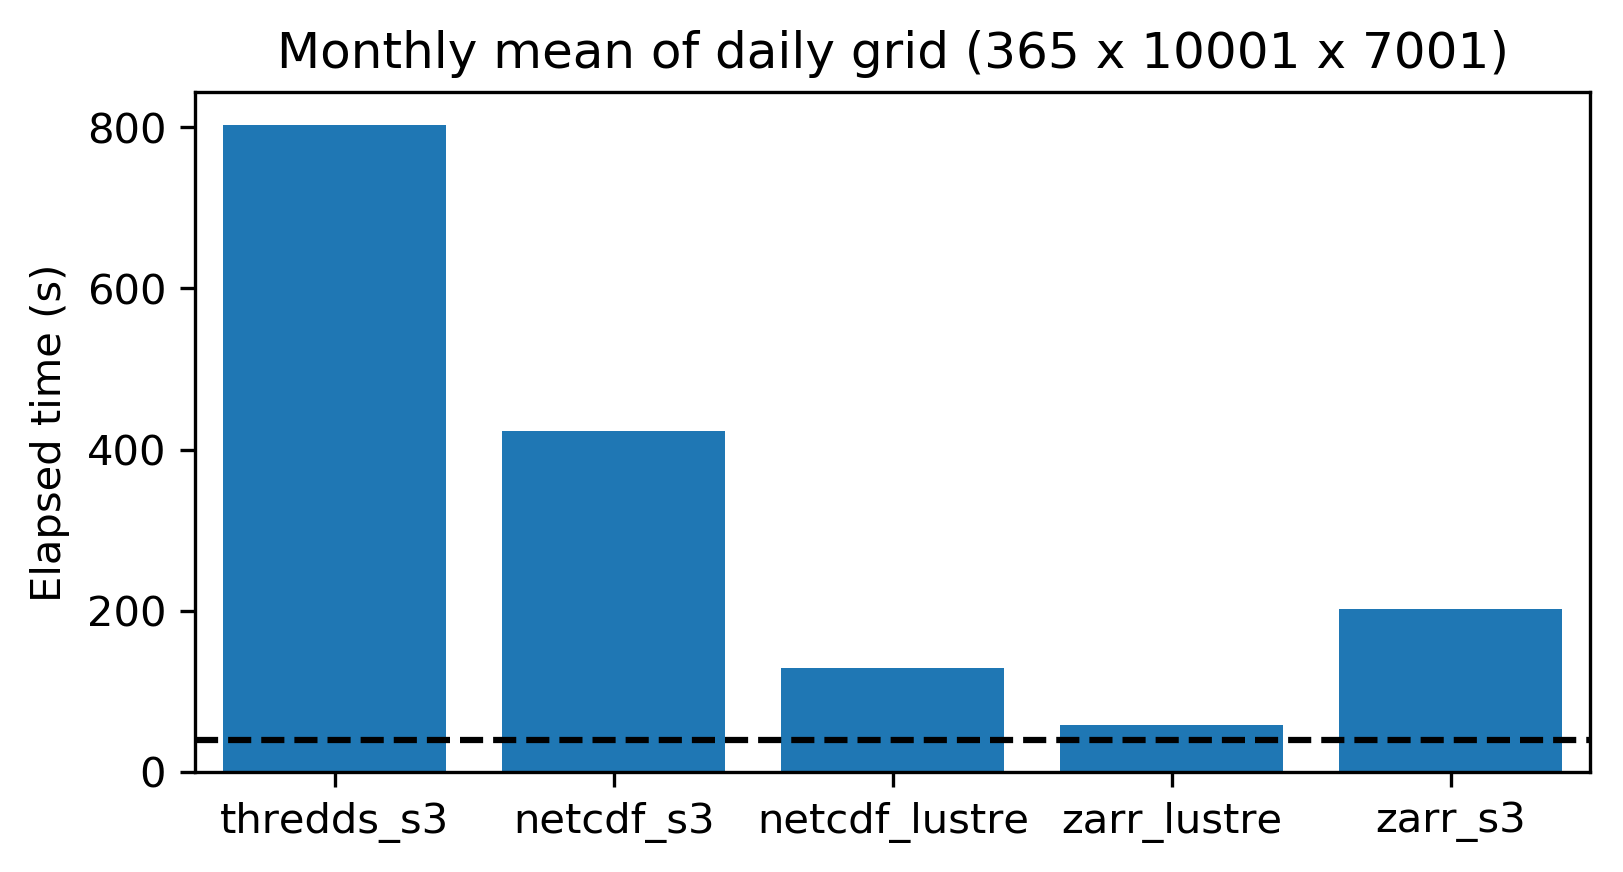

In [13]:
import numpy as np
import matplotlib.pyplot as plt

results = {'thredds_s3':[820.29, 786.2],'netcdf_s3':[400,449,420],'netcdf_lustre':[85.81,119.2,120,189],'zarr_lustre':[46.6,44,82],'zarr_s3':[197.6,207]}

fig,ax = plt.subplots(figsize=[6,3],dpi=300)
plt.bar(results.keys(),height=[np.mean(np.array(r)) for r in results.values()])
ax.set_ylabel('Elapsed time (s)')
ax.set_title('Monthly mean of daily grid (365 x 10001 x 7001)')
ax.plot([-0.5,6],[40, 40],ls='--',c='k')
ax.set_xlim((-0.5,4.5))